## Import

In [22]:
import torch
from torch.utils.data import DataLoader
import random
import shutil

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import scipy as scip
from mpl_toolkits.axes_grid1 import make_axes_locatable
from copy import copy
from torch.nn import functional as F
from numpy.linalg import norm

from EWOthello.mingpt.probe_model import BatteryProbeClassification
from EWOthello.mingpt.utils import set_seed
from EWOthello.mingpt.model import GPTConfig,  GPTforProbeIA, GPTforProbeIA_ModV1
from EWOthello.data.othello import * 
from EWOthello.mingpt.dataset import CharDataset 
import EWOthello.utils.plot_helpers as plt_utils
from EWOthello.mingpt.utils import  intervene

set_seed(44)
print(torch.cuda.is_available())
device = torch.cuda.current_device()
print(torch.cuda.get_device_name(device))

True
NVIDIA GeForce RTX 3090 Ti


In [23]:
# Get a the game dataset
othello = get(ood_num=-1, data_root=None, num_preload=1) # 11 corresponds to over 1 million games
game_dataset = CharDataset(othello) 
print("Data Loaded \n")

Max num files: 230; Use_num: 1
['gen10e5__20220324_165952.pickle']


Mem Used: 2.889 GB: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Deduplicating...
Deduplicating finished with 99999 games left
Using 20 million for training, 0 for validation
Dataset created has 99999 sequences, 61 unique words.
Data Loaded 



## Test the causal-evaluation script

Loading GPT Othello from checkpoint:  ../EWOthello/ckpts/DeanKLi_GPT_Synthetic_8L8H/GPT_Synthetic_8Layers_8Heads.ckpt
Loading Pre-trained probe for layer: 1 ../EWOthello/ckpts/DeanKLi_GPT_Synthetic_8L8H/linearProbe_Map_new_8L8H_GPT_Layer1.ckpt
Loading Pre-trained probe for layer: 2 ../EWOthello/ckpts/DeanKLi_GPT_Synthetic_8L8H/linearProbe_Map_new_8L8H_GPT_Layer2.ckpt
Loading Pre-trained probe for layer: 3 ../EWOthello/ckpts/DeanKLi_GPT_Synthetic_8L8H/linearProbe_Map_new_8L8H_GPT_Layer3.ckpt
Loading Pre-trained probe for layer: 4 ../EWOthello/ckpts/DeanKLi_GPT_Synthetic_8L8H/linearProbe_Map_new_8L8H_GPT_Layer4.ckpt
Loading Pre-trained probe for layer: 5 ../EWOthello/ckpts/DeanKLi_GPT_Synthetic_8L8H/linearProbe_Map_new_8L8H_GPT_Layer5.ckpt
Loading Pre-trained probe for layer: 6 ../EWOthello/ckpts/DeanKLi_GPT_Synthetic_8L8H/linearProbe_Map_new_8L8H_GPT_Layer6.ckpt
Loading Pre-trained probe for layer: 7 ../EWOthello/ckpts/DeanKLi_GPT_Synthetic_8L8H/linearProbe_Map_new_8L8H_GPT_Layer7.ckpt


/tmp/ipykernel_24165/1005123267.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_board = torch.tensor(target_board.clone(), dtype=torch.int64).to(device)


(0.93209124, 0.58137935)

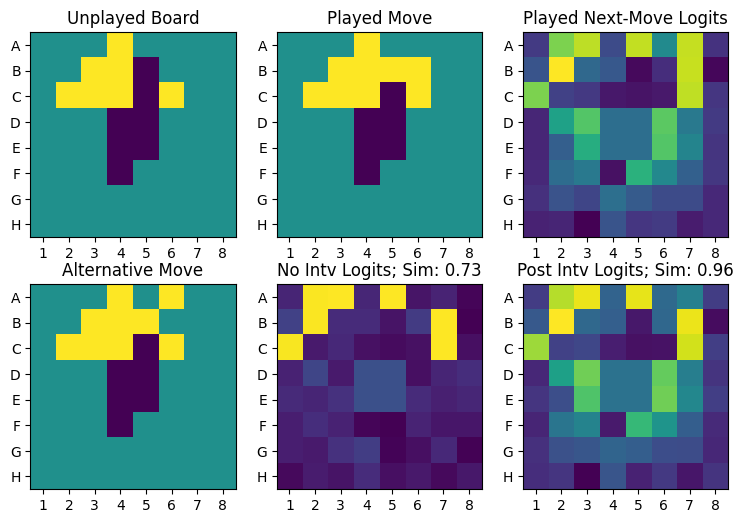

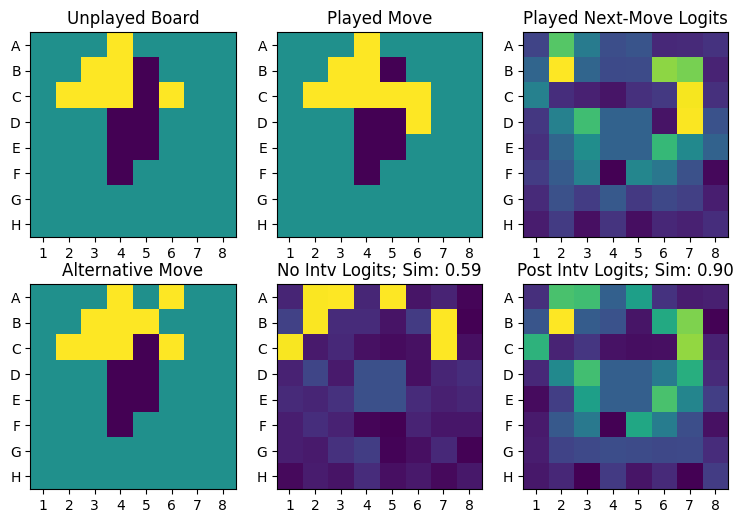

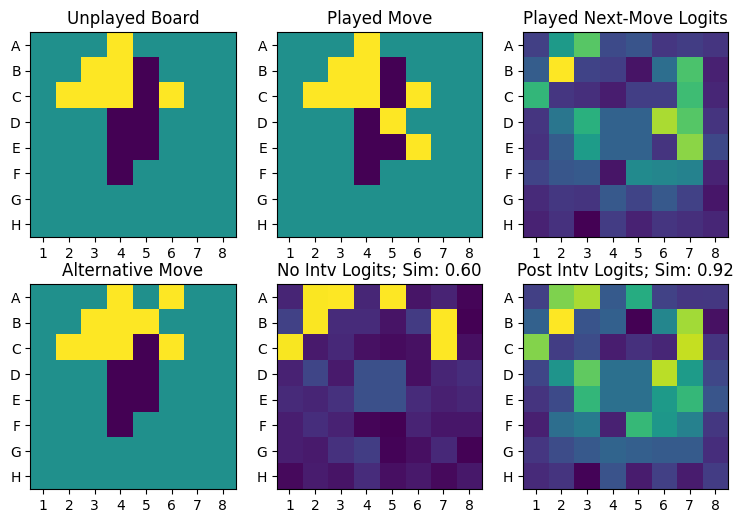

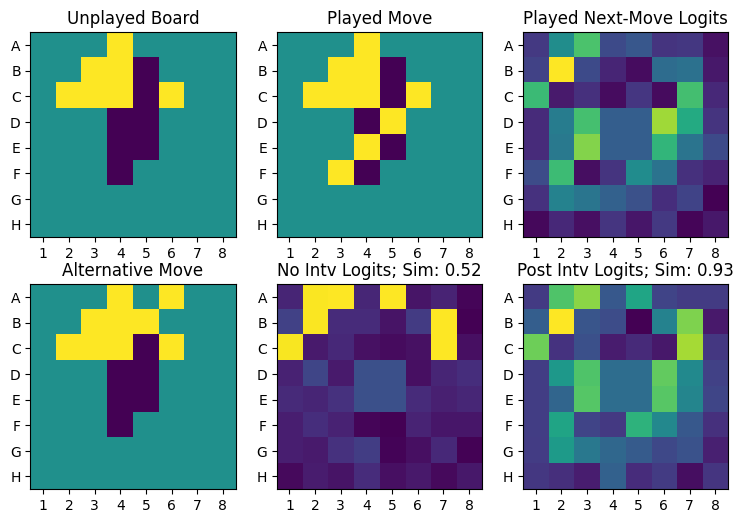

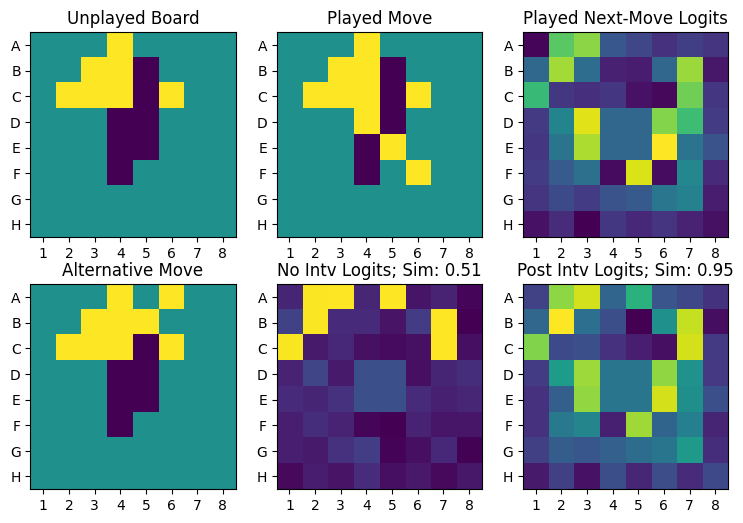

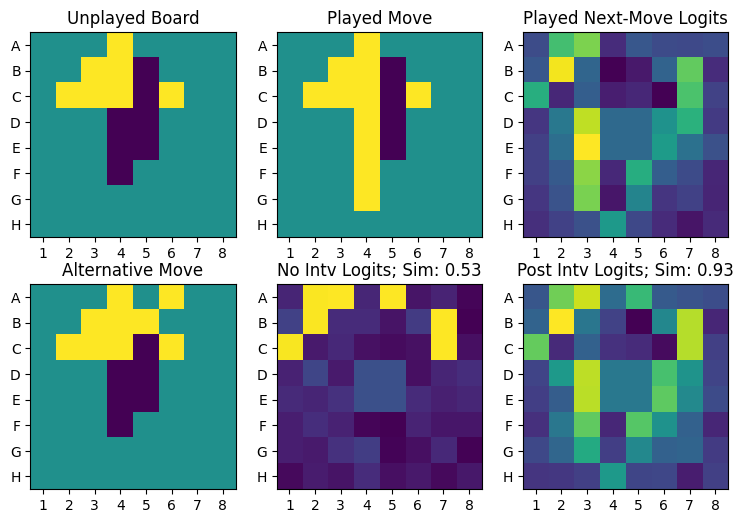

In [24]:
def convert_tbf_to_input(chunk, device, max_len=59):
    if len(chunk) != max_len:
        chunk += [-100] * (max_len - len(chunk))
    x_input = torch.tensor([game_dataset.stoi[tile] for tile in chunk], dtype=torch.long)
    return x_input[:-1].to(device)

def intervene_general(p, init_act, target_board, htd, rand_start=False):
    if rand_start:
        new_mid_act = torch.tensor(torch.rand(init_act.shape), dtype=torch.float32).to(device)
        new_mid_act.requires_grad=True
    else:
        new_mid_act = torch.tensor(init_act.clone().detach().cpu().numpy(), dtype=torch.float32).to(device)
        new_mid_act.requires_grad = True

    opt = torch.optim.Adam([new_mid_act], lr=htd["lr"])
    target_board = torch.tensor(target_board.clone(), dtype=torch.int64).to(device)
    target_board.requires_grad=False
    for i in range(htd["steps"]):
        opt.zero_grad()
        logits_running = p(new_mid_act[None, :])[0][0]  # [64, 3]
        loss = F.cross_entropy(logits_running, target_board)        
        loss = torch.mean(loss)
        loss.backward()  # by torch semantics, loss is to be minimized
        opt.step()

    return new_mid_act

def causal_intervention_logit_evaluation(x, probe_path, probe_layer, number_played_moves, verbose=False, reassertion=False):
    tbf = [game_dataset.itos[_] for _ in x.tolist()]
    ab = OthelloBoardState()
    ab.update(tbf[:number_played_moves], prt=False)
    init_board = np.array(ab.get_state()).reshape(8,8)
    valid_moves = ab.get_valid_moves()
    idx_of_interest = number_played_moves
    padding = torch.zeros(2).cuda() # Add in center two tiles with zero padding because output skips over them

    # Load the GPT Model for gameplay 
    n_layer = int(probe_path[-5:-4])
    n_head = int(probe_path[-3:-2])
    gpt_othello_ckpt = probe_path + f"GPT_Synthetic_{n_layer}Layers_{n_head}Heads.ckpt"
    if verbose: 
        print("Loading GPT Othello from checkpoint: ", gpt_othello_ckpt)
    mconf = GPTConfig(vocab_size=61, block_size=59, n_layer=n_layer, n_head=n_head, n_embd=512)
    model = GPTforProbeIA_ModV1(mconf)
    model.load_state_dict(torch.load(gpt_othello_ckpt))
    model.eval()
    model = model.to(device) 
    
    # Load the set of probes
    probe_set = []
    for layer in range(1,n_layer+1):
        probe = BatteryProbeClassification(device, probe_class=3, num_task=64, input_dim=512)
        probe_ckpt = probe_path + f"linearProbe_Map_new_{n_layer}L{n_head}H_GPT_Layer{layer}.ckpt"
        if verbose:
            print(f"Loading Pre-trained probe for layer: {layer}", probe_ckpt)
        probe.load_state_dict(torch.load(probe_ckpt))
        probe.eval()
        probe_set.append(probe)
    
    # Run the intervention sweep study
    if verbose:
        print("Run Intervention")
    htd = {"lr": 1e-3, "steps": 1000}
    if len(valid_moves) > 1:
        tbf_input = copy(tbf)[:number_played_moves]
        tbf_input.append(valid_moves[0])
        x_input = convert_tbf_to_input(tbf_input, device)
        ab_input = OthelloBoardState()
        ab_input.update(tbf_input[:number_played_moves+1], prt=False)
        input_board = np.array(ab_input.get_state())

        logit_similarity = []
        reference_similarity = []
        for alt_move in valid_moves[1:]:        
            # Compute the logits for the alternative boards passed in
            tbf_gt = copy(tbf)[:number_played_moves]
            tbf_gt.append(alt_move)
            x_gt = convert_tbf_to_input(tbf_gt, device)

            act_gt = model.forward_1st_stage(probe_layer, x_gt[None, :])[0]
            gt_board_logits, _ = probe_set[probe_layer-1](act_gt[idx_of_interest,:])  
            gt_board = torch.argmax(gt_board_logits, -1, keepdim=False).detach().cpu() 
            pred_gt, _ = model.predict(model.forward_2nd_stage(act_gt[None], probe_layer, -1)[0][0])
            pred_gt = pred_gt[idx_of_interest, 1:]
            pred_gt = torch.cat([pred_gt[:27], padding, pred_gt[27:33], padding, pred_gt[33:]], dim=0).detach().cpu().numpy()

            # Compute the logits for the board placed in by intervention
            intv_activation = model.forward_1st_stage(probe_layer, x_input[None, :])[0]
            new_activation = intervene_general(probe_set[probe_layer-1], intv_activation[idx_of_interest,:], gt_board[0], htd)
            intv_activation[number_played_moves, :] = new_activation
            reconst_board, _ = probe_set[probe_layer-1](intv_activation[idx_of_interest, :])    
            reconst_board = torch.argmax(reconst_board, -1, keepdim=False).detach().cpu().reshape(8,8)
            if reassertion:
                for layer in range(probe_layer, 8):
                    intv_activation = model.forward_2nd_stage(intv_activation[None], layer, layer+1)[0][0]
                    new_activation = intervene_general(probe_set[layer], intv_activation[idx_of_interest,:], gt_board[0], htd)
                    intv_activation[idx_of_interest, :] = new_activation
            else:
                intv_activation = model.forward_2nd_stage(intv_activation[None], probe_layer, -1)[0][0]
    
            post_intv_pred, _ = model.predict(intv_activation)
            post_intv_pred = post_intv_pred[idx_of_interest, 1:]
            post_intv_pred = torch.cat([post_intv_pred[:27], padding, post_intv_pred[27:33], padding, post_intv_pred[33:]], dim=0)
            post_intv_pred = post_intv_pred.detach().cpu().numpy()

            # Lets also compute the logits for no intervention
            no_intv_pred, _ = model.predict(model.forward_1st_stage(-1, x_input[None, :])[0])
            no_intv_pred = no_intv_pred[idx_of_interest, 1:]
            no_intv_pred = torch.cat([no_intv_pred[:27], padding, no_intv_pred[27:33], padding, no_intv_pred[33:]], dim=0)
            no_intv_pred = no_intv_pred.detach().cpu().numpy()

            cosine_similarity = np.dot(post_intv_pred, pred_gt) / norm(post_intv_pred)/norm(pred_gt)
            ref_similarity = np.dot(no_intv_pred, pred_gt) / norm(no_intv_pred)/norm(pred_gt)
            logit_similarity.append(cosine_similarity)
            reference_similarity.append(ref_similarity)

            if verbose:
                fig = plt.figure(figsize=(9, 6))
                ax = plt_utils.addAxis(fig,2,3)
                ax[0].imshow(init_board)
                ax[0].set_title("Unplayed Board")
                ax[1].imshow(gt_board.reshape(8,8))
                ax[1].set_title("Played Move")
                ax[2].imshow(pred_gt.reshape(8,8))
                ax[2].set_title("Played Next-Move Logits")
                ax[3].imshow(input_board.reshape(8,8))
                ax[3].set_title("Alternative Move")
                ax[4].imshow(no_intv_pred.reshape(8,8))
                ax[4].set_title(f"No Intv Logits; Sim: {ref_similarity:.2f}")
                ax[5].imshow(post_intv_pred.reshape(8,8))
                ax[5].set_title(f"Post Intv Logits; Sim: {cosine_similarity:.2f}")
                plt_utils.format_ax_boardImage(ax)  

        return np.mean(logit_similarity), np.mean(reference_similarity)
    else:
        return None, None


index = 499
x, _ = game_dataset[index]
probe_layer = 5
probe_path = "../EWOthello/ckpts/DeanKLi_GPT_Synthetic_8L8H/"
causal_intervention_logit_evaluation(x, probe_path, probe_layer, number_played_moves=10, verbose=True, reassertion=False)

## Run Causal-Evaluation Game Sweep

In [ ]:
def sweep_causal_interv_evaluation(game_dataset, num_games, probe_path, max_seq_len=58):
    if not os.path.exists("saved_data"):
        os.mkdir("saved_data")

    intv_data = []
    ref_data = []
    # Loop over different game sequences to get an averaged result
    for idx in tqdm(random.sample(list(range(len(game_dataset))), num_games)):
        x, _= game_dataset[idx]
        hold_probe_sim = []
        hold_ref_sim = []

        for probe_layer in np.arange(1, 9, 1):
            logit_similarity_vs_gameLength = []
            ref_similarity_vs_gameLength = []
            for number_played_moves in np.arange(0,max_seq_len,2):
                intv_sim, ref_sim = causal_intervention_logit_evaluation(x, probe_path, probe_layer, number_played_moves)
                logit_similarity_vs_gameLength.append(intv_sim)
                ref_similarity_vs_gameLength.append(ref_sim)
            hold_probe_sim.append(logit_similarity_vs_gameLength)
            hold_ref_sim.append(ref_similarity_vs_gameLength)

        intv_data.append(np.array(hold_probe_sim))
        ref_data.append(np.array(hold_ref_sim))

        # save benchmark since this may take a while
        with open("saved_data/save_calc.pickle", 'wb') as fhandle:
            pickle.dump({"sim_data": intv_data, "ref_data":ref_data}, fhandle)

    return intv_data, ref_data

number_games_use=50
probe_path = "../EWOthello/ckpts/DeanKLi_GPT_Synthetic_8L8H/"
_ = sweep_causal_interv_evaluation(game_dataset, number_games_use, probe_path)

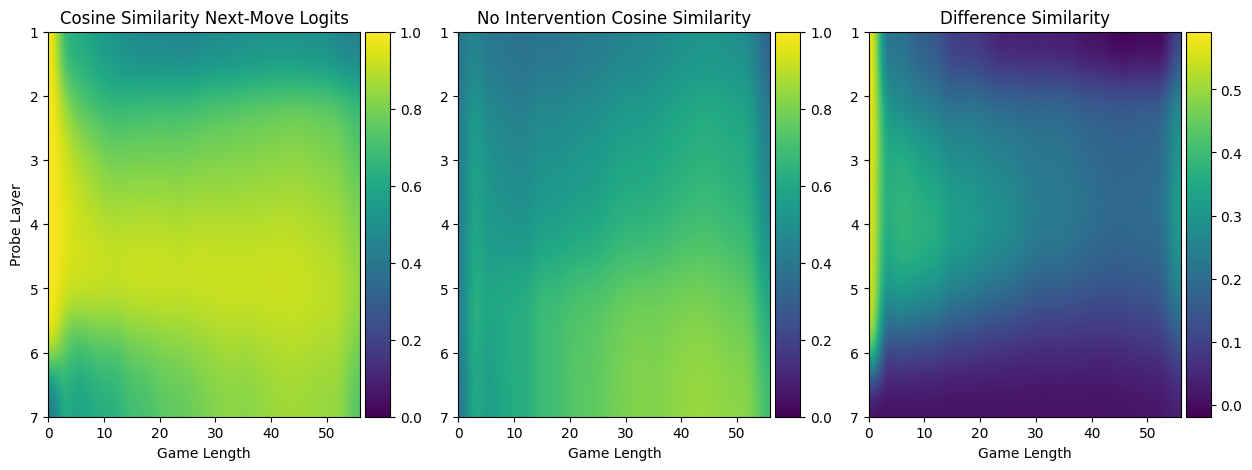

In [28]:
with open("saved_data/DeanKLi_GPT8L8H_SweepData.pickle", 'rb') as fhandle:
    data = pickle.load(fhandle)
    sim_data = np.array(data["sim_data"])
    ref_data = np.array(data["ref_data"])
    sim_data[np.where(sim_data==None)] = np.nan
    ref_data[np.where(ref_data==None)] = np.nan

    mean_sim = np.nanmean(sim_data, axis=0).astype(float)
    mean_ref = np.nanmean(ref_data, axis=0).astype(float)
   
    probe_layer = np.arange(1,8,1)
    game_len = np.arange(0,58,2)
    extent= (min(game_len), max(game_len), max(probe_layer), min(probe_layer))

    fig = plt.figure(figsize=(15, 5))
    ax = plt_utils.addAxis(fig,1,3)

    im = ax[0].imshow(mean_sim, extent=extent,  aspect="auto", vmin=0, vmax=1, interpolation="bicubic")
    plt_utils.addColorbar(fig, ax[0], im)
    im = ax[1].imshow(mean_ref, extent=extent, aspect="auto", vmin=0, vmax=1, interpolation="bicubic")
    plt_utils.addColorbar(fig, ax[1], im)
    im = ax[2].imshow(mean_sim - mean_ref, extent=extent, aspect="auto", interpolation="bicubic")
    plt_utils.addColorbar(fig, ax[2], im)
    
    ax[0].set_xlabel('Game Length')
    ax[1].set_xlabel('Game Length')
    ax[2].set_xlabel("Game Length")
    ax[0].set_ylabel("Probe Layer")
    ax[0].set_title("Cosine Similarity Next-Move Logits")
    ax[1].set_title("No Intervention Cosine Similarity")
    ax[2].set_title("Difference Similarity")